# APS 4 - Mecânica dos Sólidos 

**Feito por:** Carolina Hirschheimer, Thiago Hampl, Rodrigo Nigri, Natália Carreras

## Importando as bibliotecas necessárias

In [1]:
from funcoesTermosol import *
import numpy as np
from math import *
import matplotlib.pyplot as plt

## Importando a base de dados

In [2]:
# Dados 
# nn: número de nós 
# N: matriz dos nós
# nm: número de membros
# Inc: matriz de incidência
# nc: número de cargas
# F: forças
# nr: número de restrições
# R: restrições 

[nn,N,nm,Inc,nc,F,nr,R] = importa('entrada2.xls')

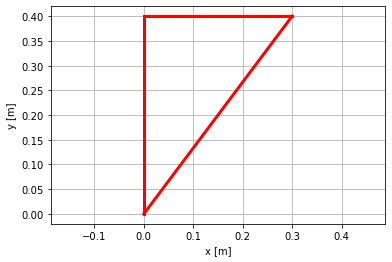

In [3]:
plota(N,Inc)

## Implementando funções de Jacobi e Gauss-Seidel

In [4]:
def jacobi(K,F,ite,tol):
    c = 0
    if type(K) == list:
        U = np.zeros((len(K),1))
        n = len(K)
    else:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    U_copy = U.copy()
    while c < ite:
        for i in range(n):
            U_copy[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_copy[i][0] -= K[i][j] * U[j][0]
            U_copy[i][0] /= K[i][i]

        if 0 not in U:
            error = []
            for i,j in zip(U_copy,U):
                error.append(abs((i-j)/j))
            if max(error) < tol:
                return U
        U = U_copy.copy() 
        c += 1
    return U

def gauss_seidel(K,F,ite,tol):
    c = 0
    if type(K) == list:
        U = np.zeros((len(K),1))
        n = len(K)
    else:
        U = np.zeros((K.shape[0],1))
        n = K.shape[0]
    U_copy = U.copy()
    while c < ite:
        for i in range(n):
            U_copy[i][0] = F[i]
            for j in range(n):
                if j != i:
                    U_copy[i][0] -= K[i][j] * U_copy[j][0]
            U_copy[i][0] /= K[i][i]

        if 0 not in U:
            error = []
            for i,j in zip(U_copy,U):
                error.append(abs((i-j)/j))
            if max(error) < tol:
                return U
        U = U_copy.copy() 
        c += 1
    return U

## Cálculo da Matriz U

In [5]:
## Matriz de conectivide
M_conectividade = []

i=0

while (i<nm):
    c_ = nn*[0]
    c_[int(Inc[i,0])-1] = -1
    c_[int(Inc[i,1])-1] = 1
    M_conectividade.append(c_)   
    i+=1
    
# Matriz de conectividade transposta
M_conectividade_transposta = np.array(M_conectividade).T

# Matriz de membros
M_membros = np.matmul(N, M_conectividade_transposta)
M_membros

#Se, Ke e Kg
Kg = np.zeros((nn*2, nn*2))
for i in range(0, nm):
    E = Inc[i,2]
    A = Inc[i,3]
    L = sqrt(((N[0][int(Inc[:,0][i])-1]-N[0][int(Inc[:,1][i])-1])**2+(N[1][int(Inc[:,0][i])-1]-N[1][int(Inc[:,1][i])-1])**2))
    k = E*A/L
    
    M_membros_ = M_membros[:,i]
    M_membros_.shape = [len(M_membros), 1]
    
    Se = (k * np.matmul(M_membros_, np.transpose(M_membros_))) / (np.linalg.norm(M_membros[:,i])**2)

    M_conectividade_ = M_conectividade_transposta[:,i]
    M_conectividade_.shape = [len(M_conectividade_transposta), 1]
    
    Ke = np.kron(np.matmul(M_conectividade_, np.transpose(M_conectividade_)), Se)
    
    Kg += Ke
    
# Aplicando condições de contorno
M_forcas = np.delete(F, R.astype(int))
M_Kg = np.delete(Kg, R.astype(int),0)
M_Kg = np.delete(M_Kg, R.astype(int), 1)

### Utilizando Jacobi

In [6]:
U_j = jacobi(M_Kg, M_forcas, 1000, 1e-5)
U_j_adj = np.zeros((nn*2,1))
i = 0
for n in range(len(U_j_adj)):
    if n not in R:
        U_j_adj[n] += U_j[i]
        i += 1
print("Deslocamentos por Jacobi [m]")
print(U_j_adj)

Deslocamentos por Jacobi [m]
[[ 0.00000000e+00]
 [-9.52376350e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60713913e-06]
 [-4.01786587e-06]]


### Utilizando Gauss-Seidel

In [7]:
U_gs = gauss_seidel(M_Kg, M_forcas, 1000, 1e-5)
U_gs_adj = np.zeros((nn*2,1))
i = 0
for e in range(len(U_gs_adj)):
    if e not in R:
        U_gs_adj[e] += U_gs[i]
        i += 1
print("Deslocamentos por Gauss-Seidel [m]")
print(U_gs_adj)

Deslocamentos por Gauss-Seidel [m]
[[ 0.00000000e+00]
 [-9.52374559e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60713664e-06]
 [-4.01784609e-06]]


### Utilizando forma geral

In [15]:
U_general = np.linalg.solve(M_Kg, M_forcas)
Ut = np.zeros((nn*2,1))
i = 0
for e in range(len(Ut)):
    if e not in R:
        Ut[e] += U_general[i]
        i += 1
print("Deslocamentos pela forma geral [m]")
print(Ut)

Deslocamentos pela forma geral [m]
[[ 0.00000000e+00]
 [-9.52380952e-07]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 1.60714286e-06]
 [-4.01785714e-06]]


## Reações de Apoio

In [16]:
print("Reacoes de apoio [N]")
P = np.matmul(Kg,U_general_adj)
P_r = np.zeros((nr,1))
for i in range(nr):  
    index = int(R[i])
    P_r[i] = P[index]    
print(P_r)

Reacoes de apoio [N]
[[  75.]
 [-225.]
 [ 100.]]


## Deformações, tensões e forças

In [26]:
Epsi=[]
Ti=[]
Fi=[]
for i in range (nm):
        
    M = [Ut[(int(Inc[i, 0])-1)*2], Ut[(int(Inc[i, 0])-1)*2 +1], Ut[(int(Inc[i, 1])-1)*2], Ut[int(Inc[i, 1]-1)*2 +1]]
    
    L = sqrt(((N[0][int(Inc[:,0][i])-1]-N[0][int(Inc[:,1][i])-1])**2+( N[1][int(Inc[:,0][i])-1]-N[1][int(Inc[:,1][i])-1])**2))  

    E =  Inc[i, 2]
    A = Inc[i,3]
    k = E*A/L
    
    s = (N[1][int(Inc[:,1][i])-1]-N[1][int(Inc[:,0][i])-1])/L
    c = (N[0][int(Inc[:,1][i])-1]-N[0][int(Inc[:,0][i])-1])/L
    
    C = [-c, -s, c, s]

    Eps = (1/L) * np.matmul(C, M)
    T = Eps*E
    F= T*A
    
    Epsi.append(Eps.tolist())
    Ti.append(T.tolist())
    Fi.append(F.tolist())

Epsi = np.array(Epsi)
Fi = np.array(Fi)
Ti = np.array(Ti)

### Deformações

In [27]:
print("Deformacoes []")
print(Epsi)

Deformacoes []
[[ 2.38095238e-06]
 [ 5.35714286e-06]
 [-2.97619048e-06]]


### Forças internas

In [28]:
print("Forcas internas [N]")
print(Fi)

Forcas internas [N]
[[ 100.]
 [ 225.]
 [-125.]]


### Tensões internas

In [29]:
print("Tensões internas [Pa]") 
print(Ti)

Tensões internas [Pa]
[[ 500000.]
 [1125000.]
 [-625000.]]


## Gera saída

In [30]:
geraSaida('saida_teste',Ft,Ut,Epsi,Fi,Ti)